In [1]:
import os
import ast
import re
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import constants

# Summarize baseline results into Pandas DataFrame

In [2]:
def summarize(path, fname):
    model_meta = pd.read_parquet(os.path.join(path, fname))
    def replace(x):
        try:
            return ast.literal_eval(x)
        except:
            return x
    for col in ['train_loss', 'train_acc', 'valid_loss', 'valid_acc']:
        try:
            model_meta[col] = model_meta[col].apply(replace)
        except:
            pass

    model_meta['epochs'] = model_meta['train_loss'].apply(len)
    model_meta['final_train_loss'] = model_meta['train_loss'].apply(lambda x: x[-1])
    model_meta['final_valid_acc'] = model_meta['valid_acc'].apply(lambda x: x[-1])
    model_meta['final_valid_loss'] = model_meta['valid_loss'].apply(lambda x: x[-1])
    model_meta['best_valid_loss'] = model_meta['valid_loss'].apply(min)

    return model_meta

In [32]:
model_meta = pd.DataFrame()

root_dir = os.path.join(constants.FINE_TUNING_RESULTS_DIR,
                        'combined',
                        'fixed_batch_size')
exp_dir = ['combined_s_20k_t_20k']
    
for d in exp_dir:
    for f in os.listdir(os.path.join(root_dir, d)):
        if f.endswith('.parquet'):
            trial_results = summarize(os.path.join(root_dir, d), f)
            _, iter_idx, _ = re.split('[_.]', f)
            trial_results.loc[:, 'iter_idx'] = iter_idx

            try:
                with open(os.path.join(root_dir, d, f'args_{iter_idx}.json')) as arg_f:
                    args = json.load(arg_f)
            except OSError:
                print('No corresponding args.json file associated with trial!')

            for key in ['num_epochs', 'lr', 'batch_size', 'train_seed', 'hidden_size', 'data_sampler_seed',
                        'n_source_samples', 'n_target_samples']:
                trial_results.loc[:, key] = args[key]

            model_meta = model_meta.append(trial_results, ignore_index=True)

model_meta.columns = [c.replace('test_test_', 'test_') for c in model_meta.columns]      

# Summarize performance for trained models

In [33]:
performance_cols = ['mimic_test_loss', 'mimic_test_acc', 'mimic_test_auc',
                    'chexpert_test_loss', 'chexpert_test_acc', 'chexpert_test_auc']

In [34]:
model_meta.max()[performance_cols]

mimic_test_loss       0.594347
mimic_test_acc        0.838305
mimic_test_auc        0.901002
chexpert_test_loss     0.57168
chexpert_test_acc      0.86575
chexpert_test_auc     0.921686
dtype: object

In [35]:
model_meta.mean()[performance_cols]

mimic_test_loss       0.588659
mimic_test_acc        0.834085
mimic_test_auc        0.898877
chexpert_test_loss    0.569269
chexpert_test_acc     0.858250
chexpert_test_auc     0.917180
dtype: float64

In [36]:
model_meta.std()[performance_cols]

mimic_test_loss       0.005060
mimic_test_acc        0.004139
mimic_test_auc        0.001842
chexpert_test_loss    0.002632
chexpert_test_acc     0.007438
chexpert_test_auc     0.005484
dtype: float64

# Visualize training and validation losses

In [37]:
def plot_losses(df, loss_type='train', ax=None):
   
    key = f'{loss_type}_loss'
    max_len = max([len(ele) for ele in df.loc[:, key].values])
    stackable = [np.pad(arr, (0, max_len - len(arr)), constant_values=np.nan) for arr in df.loc[:, key].values]
    losses = np.stack(stackable)

    avg_loss = np.mean(losses, axis=0)
    upper_ = avg_loss + np.std(losses, axis=0)
    lower_ = avg_loss - np.std(losses, axis=0)
    x_ = np.arange(len(upper_))

    ax.fill_between(x_, lower_, upper_, color='k', alpha=0.1)
    ax.plot(avg_loss, 'k--')
    ax.plot(losses.T)
    ax.legend(['average loss', 'iter 0', 'iter 1', 'iter 2', '+/- std'], loc='upper right')

    ax.set_title(f'{loss_type} loss'.title())
    ax.set_xlabel('epochs')
    ax.set_ylabel('BCE loss')


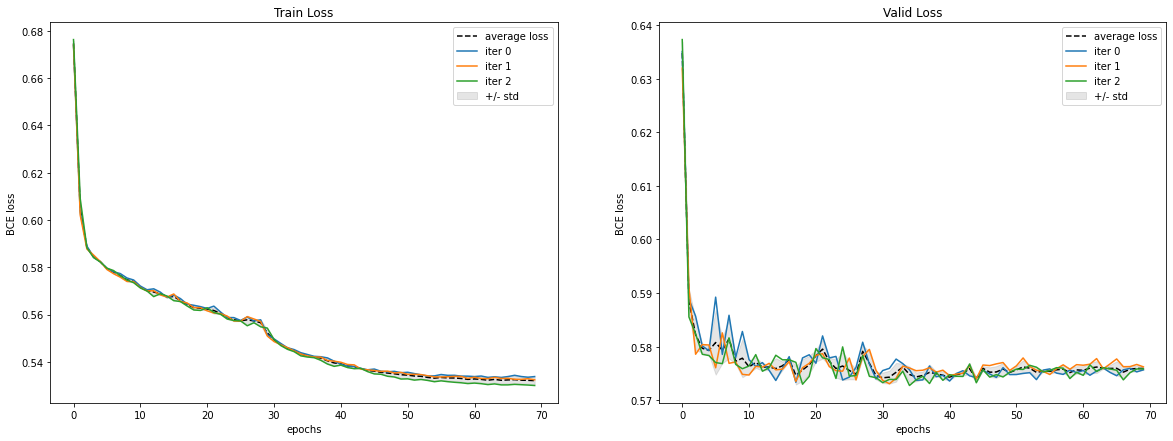

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

plot_losses(model_meta, loss_type='train', ax=ax[0])
plot_losses(model_meta, loss_type='valid', ax=ax[1])

# Visualize training and validation accuracies for the two training phases

In [39]:
def plot_accuracies(df, acc_type='train', ax=None):

    key = f'{acc_type}_acc'
    max_len = max([len(ele) for ele in df.loc[:, key].values])
    stackable = [np.pad(arr, (0, max_len - len(arr)), constant_values=np.nan) for arr in df.loc[:, key].values]
    losses = np.stack(stackable)

    avg_loss = np.mean(losses, axis=0)
    upper_ = avg_loss + np.std(losses, axis=0)
    lower_ = avg_loss - np.std(losses, axis=0)
    x_ = np.arange(len(upper_))

    ax.fill_between(x_, lower_, upper_, color='k', alpha=0.1)
    ax.plot(avg_loss, 'k--')
    ax.plot(losses.T)
    ax.legend(['average loss', 'iter 0', 'iter 1', 'iter 2', '+/- std'], loc='lower right')

    ax.set_title(f'{acc_type} Accuracy'.title())
    ax.set_xlabel('epochs')
    ax.set_ylabel('Accuracy')


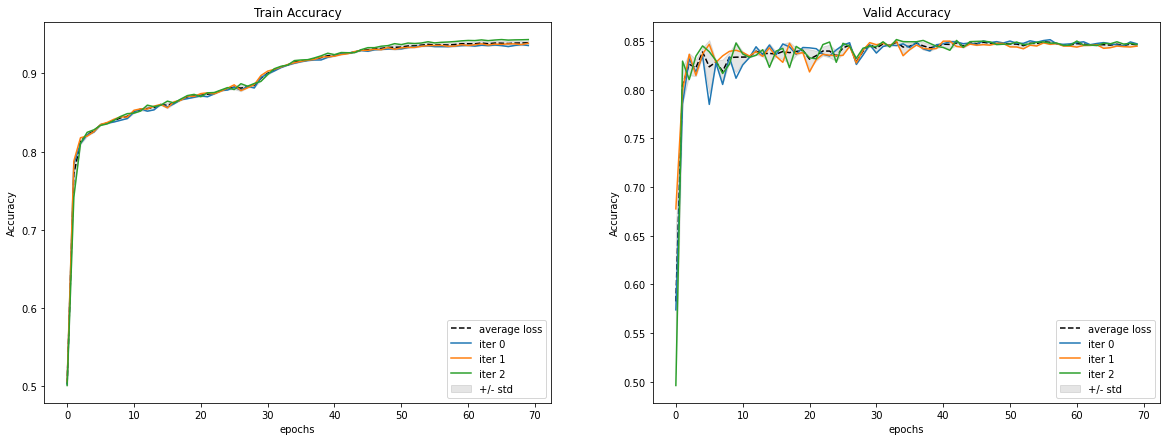

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

plot_accuracies(model_meta, acc_type='train', ax=ax[0])
plot_accuracies(model_meta, acc_type='valid', ax=ax[1])